In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
import sys
sys.path.append("/export/raid1/home/styvesg/code/")
sys.path.append("/export/raid1/home/styvesg/code/nsd_gnet8x/")
sys.path.append("/export/raid1/home/styvesg/code/nsd_manifold/")

import nsd_gnet8x.src.numpy_utility as pnu
from nsd_gnet8x.src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from nsd_gnet8x.src.config import *

from nsd_manifold.src.utility import *
from nsd_manifold.src.sampler import *

%matplotlib inline

In [5]:
input_dir = "../nsd_gnet8x/output/multisubject/gnet8j64t192_mpf_general_Jan-25-2023_1316/"
output_dir = input_dir

stim_dir = root_dir+'../../data/nsd/stims/'
voxel_dir = root_dir+'../../data/nsd/voxels/'

exp_design_file = root_dir+"../../data/nsd/nsd_expdesign.mat"

## ROIs

In [6]:
from nsd_gnet8x.src.file_utility import load_mask_from_nii, view_data
from nsd_gnet8x.src.roi import roi_map, iterate_roi

group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'all', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], np.arange(1, 24), [24,25,0]]

In [27]:
plot_roi = ['V1', 'V2', 'V3', 'hV4', 'MST', 'V3ab', 'MT', 'PHC', 'VO', 'LO', 'IPS',]
roi_cmap = {roi: cm.get_cmap('rainbow', len(plot_roi))(k) for k,roi in enumerate(plot_roi)}

# Reload joined GNet model files

In [13]:
import torch
use_device = "cuda:0"

joined_checkpoint = torch.load(input_dir + 'model_params_final', map_location=use_device)
print (joined_checkpoint.keys())

dict_keys(['num_epochs', 'batch_size', 'holdout_frac', 'best_params', 'final_params', 'trn_loss_history', 'hold_loss_history', 'hold_cc_history', 'best_epoch', 'best_joint_cc_score', 'val_cc', 'input_mean', 'brain_nii_shape', 'voxel_index', 'voxel_roi', 'voxel_mask'])


In [14]:
subjects = list(joined_checkpoint['voxel_mask'].keys())
voxel_mask = joined_checkpoint['voxel_mask']
voxel_roi  = joined_checkpoint['voxel_roi']
voxel_index= joined_checkpoint['voxel_index']
brain_nii_shape= joined_checkpoint['brain_nii_shape']

In [15]:
for s,v in voxel_mask.items():
    print (s, ': ', np.sum(v))

1 :  11838
2 :  10325
3 :  11356
4 :  9470
5 :  9565
6 :  11827
7 :  9162
8 :  10178


# Load a few example image from the imagenet training set

In [8]:
imagenet_root = root_dir + "../../data/imagenet/"

In [9]:
from torchvision import datasets, transforms

data_transform = transforms.Compose([
            transforms.Resize(227), # smallest dimension will be resized to that size
            transforms.CenterCrop((227, 227)), # crop the edges of non-square images
            transforms.ToTensor(), # this automatically convert from uint8 to float in range [0,1]
        ])

inet_val = datasets.ImageNet(imagenet_root, 'val', transform=data_transform)
#inet_trn = datasets.ImageNet(imagenet_root, 'train', transform=data_transform)

In [10]:
label_map = inet_val.classes
wnids_map = inet_val.wnids

In [11]:
print (len(label_map))
print (len(wnids_map))

1000
1000
1280449


---
# Calculate hierarchical distance form wordnet IDs.

In [16]:
import nltk
#nltk.download()
#download identifier: wordnet, omw-1.4

from nltk.corpus import wordnet as wn

wnsynset = []
for l in wnids_map:
    wnsynset += [  wn.synset_from_pos_and_offset(l[0], int(l[1:])), ]
    
ND_mat = np.zeros(shape=(len(label_map), len(label_map)))
for i,wi in enumerate(wnsynset):
    for j,wj in enumerate(wnsynset):
        ND_mat[i,j] = wi.path_similarity(wj)
D_mat = ND_mat**(-1) - 1

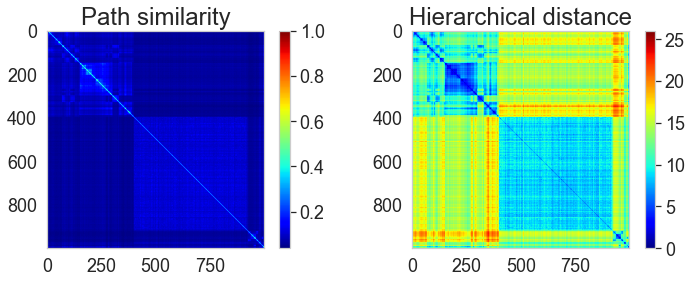

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Path similarity')
plt.imshow(ND_mat, cmap='jet')
plt.colorbar()
plt.grid(False)
plt.subplot(1,2,2)
plt.title('Hierarchical distance')
plt.imshow(D_mat, cmap='jet')
plt.colorbar()
plt.grid(False)

# Load imagenet predictions

In [18]:
data_set = h5py.File(input_dir + 'imagenet_val_pred_all.h5py', 'r')
image_pred_dict = embed_dict({s: np.copy(d) for s,d in data_set.items()})
data_set.close()
print (image_pred_dict.keys())

dict_keys(['brain_nii_shape', 'label', 'pred', 'voxel_index', 'voxel_mask', 'voxel_roi'])


In [19]:
print (len(image_pred_dict['label']))
print (image_pred_dict['pred'].keys())

50000
dict_keys(['1', '2', '3', '4', '5', '6', '7', '8'])


In [20]:
subj = 1
print (image_pred_dict['pred']['%s'%subj].shape)

(50000, 11838)


## Calculate few-shot accuracy on validation image predicted responses

In [168]:
from nsd_manifold.src.geometry import k_rand_label_index, geometry, PCA_geometry, prD

In [ ]:
m = 5
K = 1000
V = 300
n_samples = 16

pred_id = image_pred_dict['label']

roiwise_K_shot_err, roiwise_K_shot_std = {}, {}
for s in subjects:

    print ('--- Subject %s ---' %s)
    roiwise_K_shot_err[s] = {}
    roiwise_K_shot_std[s] = {}
    
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_names):

        print (' -- ROI: %s --'%roi_name)
        A = np.random.randn(np.sum(roi_mask),V) / np.sqrt(V)
        #pred = subject_imnet_pred[s][:,roi_mask]@A
        pred = image_pred_dict['pred']['%s'%s][:,roi_mask]@A
        
        K_shot_err = np.zeros(shape=(K, K), dtype=np.float32)
        K_shot_std = np.zeros(shape=(K, K), dtype=np.float32)
        for l1 in tqdm(range(K-1)):
            idx1, cidx1 = k_rand_label_index(pred_id, 0, l1)
            for l2 in range(l1+1, K):
                idx2, cidx2 = k_rand_label_index(pred_id, 0, l2)

                err_ab, err_ba = [], []
                for _ in range(n_samples):
                    np.random.shuffle(cidx1)
                    np.random.shuffle(cidx2)

                    m1 = np.mean(pred[cidx1[:m]], axis=0, keepdims=True) # [1, voxels]
                    m2 = np.mean(pred[cidx2[:m]], axis=0, keepdims=True) # [1, voxels] 

                    # how many of the remaining obj1 example are closer to m1 than m2?
                    x = pred[cidx1[m:]]
                    err_ab += [np.mean((np.sum((x-m1)**2, axis=1) > np.sum((x-m2)**2, axis=1)).astype(np.float)),]

                    # how many of the remaining obj2 example are closer to m2 than m1?
                    x = pred[cidx2[m:]]
                    err_ba += [np.mean((np.sum((x-m1)**2, axis=1) < np.sum((x-m2)**2, axis=1)).astype(np.float)),]

                K_shot_err[l1,l2] = np.mean(np.array(err_ab))
                K_shot_err[l2,l1] = np.mean(np.array(err_ba))
                K_shot_std[l1,l2] = np.std(np.array(err_ab))
                K_shot_std[l2,l1] = np.std(np.array(err_ba))

        roiwise_K_shot_err[s][roi_name] = K_shot_err
        roiwise_K_shot_std[s][roi_name] = K_shot_std

--- Subject 1 ---
 -- ROI: V1 --


100%|██████████| 999/999 [27:20<00:00,  1.64s/it]


 -- ROI: V2 --


100%|██████████| 999/999 [27:23<00:00,  1.65s/it]


 -- ROI: V3 --


100%|██████████| 999/999 [27:40<00:00,  1.66s/it]


 -- ROI: hV4 --


100%|██████████| 999/999 [27:36<00:00,  1.66s/it]


 -- ROI: V3ab --


100%|██████████| 999/999 [27:25<00:00,  1.65s/it]


 -- ROI: LO --


100%|██████████| 999/999 [27:29<00:00,  1.65s/it]


 -- ROI: IPS --


100%|██████████| 999/999 [27:35<00:00,  1.66s/it]


 -- ROI: VO --


100%|██████████| 999/999 [27:24<00:00,  1.65s/it]


 -- ROI: PHC --


100%|██████████| 999/999 [27:35<00:00,  1.66s/it]


 -- ROI: MT --


100%|██████████| 999/999 [27:41<00:00,  1.66s/it]


 -- ROI: MST --


 24%|██▎       | 235/999 [11:38<34:20,  2.70s/it]

In [ ]:
save_stuff( output_dir + 'imagenet_manifold_%dshot_err_all'%(m), 
    flatten_dict({'err': roiwise_K_shot_err,
                  'std': roiwise_K_shot_std,
                  #'objID1k': np.array(objID)
            }))

# Load training image set prediction and calculate concept manifold linear geometry and SNR characteristics

In [29]:
from nsd_manifold.src.geometry import k_rand_label_index, geometry, PCA_geometry, prD

In [164]:
K = 1000
P = 700
V = 300
m = 5

for subj in trn_subjects:
    manifold_data = {'R0': {}, 'Rs': {}, 'Us': {}, 'rproj': {}, 'P': P, 'K': K, 'V': V}
    
    ###
    data_set = h5py.File(input_dir + 'imagenet_trn_pred_subj%02d.h5py'%subj, 'r')
    imnet_pred_dict = embed_dict({s: np.copy(d) for s,d in data_set.items()})
    data_set.close()
    print (imnet_pred_dict.keys())
    
    #imnet_pred_dict['pred'] -= np.mean(imnet_pred_dict['pred'], axis=0, keepdims=True)
    #imnet_pred_dict['pred'] /= np.std(imnet_pred_dict['pred'], axis=0, keepdims=True)
    
    ###
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[subj], roi_map, group_names):
        manifolds = []
        pred = imnet_pred_dict['pred'][:, roi_mask]  
        A = np.random.randn(np.sum(roi_mask),V) / np.sqrt(V)

        for l in tqdm(range(K)):
            idxa, cidxa = k_rand_label_index(imnet_pred_dict['label'], 0, l)
            np.random.shuffle(cidxa)
            if len(cidxa)<P:
                cidxa = np.concatenate([cidxa, cidxa[np.random.randint(0,len(cidxa),P-len(cidxa))]], axis=0)
            manifolds += [pred[cidxa[:P]]@A,]

        manifolds = np.array(manifolds)
        manifold_data['rproj'][roi_name] = A
        print (manifolds.shape)
        
        ###
        R0s, Rs, Us = [],[],[]
        for l in tqdm(range(K)):
            r0a, Ra, Ua = PCA_geometry(manifolds[l])
            if r0a is not None:
                R0s += [r0a,]
                Rs  += [Ra]
                Us  += [Ua,]
            else:
                R0s += [np.zeros(shape=(V)),]
                Rs += [np.zeros(shape=(V)),]
                Us  += [np.zeros(shape=(V, V)),]            

        manifold_data['R0'][roi_name] = np.array(R0s)
        manifold_data['Rs'][roi_name]  = np.array(Rs)
        manifold_data['Us'][roi_name]  = np.array(Us)
        
        del manifolds
        
    save_stuff( output_dir + 'imagenet_manifold_subj%02d'%subj, flatten_dict(manifold_data))
    
    ###
    manifold_dict = {'Sign': {}, 'Bias': {}, 'Nsa': {}, 'Nsb': {}, 'Nss': {}, 'Ds': {}, 'SNR': {}, 'm': m, 'P': P}
    for roi_name in manifold_data['R0'].keys():
        manifold_dict['Sign'][roi_name], manifold_dict['Bias'][roi_name], manifold_dict['Ds'][roi_name], \
        manifold_dict['Nsa'][roi_name], manifold_dict['Nsb'][roi_name], manifold_dict['Nss'][roi_name], \
        manifold_dict['SNR'][roi_name] = \
            geometry(manifold_data['R0'][roi_name], 
                     manifold_data['Rs'][roi_name], 
                     manifold_data['Us'][roi_name], m, P)
        #signal, bias, Ds, nsa, nsb, nno, SNR
    
    save_stuff( output_dir + 'imagenet_manifold_subj%02d_SNR'%subj, flatten_dict(manifold_dict))

dict_keys(['brain_nii_shape', 'label', 'pred', 'voxel_index', 'voxel_mask', 'voxel_roi'])


100%|██████████| 1000/1000 [01:58<00:00,  8.47it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:21<00:00, 12.24it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:20<00:00, 49.25it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:31<00:00, 31.61it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:13<00:00, 75.26it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:46<00:00,  9.36it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:13<00:00, 76.00it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:10<00:00, 92.51it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:08<00:00, 114.61it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:04<00:00, 244.58it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [09:50<00:00,  1.69it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:07<00:00, 135.03it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:49<00:00,  9.17it/s]


saved R0.V1 in h5py file
saved R0.V2 in h5py file
saved R0.V3 in h5py file
saved R0.hV4 in h5py file
saved R0.V3ab in h5py file
saved R0.LO in h5py file
saved R0.IPS in h5py file
saved R0.VO in h5py file
saved R0.PHC in h5py file
saved R0.MT in h5py file
saved R0.MST in h5py file
saved R0.all in h5py file
saved R0.other in h5py file
saved Rs.V1 in h5py file
saved Rs.V2 in h5py file
saved Rs.V3 in h5py file
saved Rs.hV4 in h5py file
saved Rs.V3ab in h5py file
saved Rs.LO in h5py file
saved Rs.IPS in h5py file
saved Rs.VO in h5py file
saved Rs.PHC in h5py file
saved Rs.MT in h5py file
saved Rs.MST in h5py file
saved Rs.all in h5py file
saved Rs.other in h5py file
saved Us.V1 in h5py file
saved Us.V2 in h5py file
saved Us.V3 in h5py file
saved Us.hV4 in h5py file
saved Us.V3ab in h5py file
saved Us.LO in h5py file
saved Us.IPS in h5py file
saved Us.VO in h5py file
saved Us.PHC in h5py file
saved Us.MT in h5py file
saved Us.MST in h5py file
saved Us.all in h5py file
saved Us.other in h5py 

100%|██████████| 1000/1000 [01:31<00:00, 10.94it/s]


Second pass


100%|██████████| 1000/1000 [22:42<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:30<00:00, 11.03it/s]


Second pass


100%|██████████| 1000/1000 [22:32<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:31<00:00, 10.96it/s]


Second pass


100%|██████████| 1000/1000 [21:48<00:00,  1.31s/it]


First pass


100%|██████████| 1000/1000 [01:28<00:00, 11.26it/s]


Second pass


100%|██████████| 1000/1000 [23:01<00:00,  1.38s/it]


First pass


100%|██████████| 1000/1000 [01:31<00:00, 10.98it/s]


Second pass


100%|██████████| 1000/1000 [22:44<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:27<00:00, 11.43it/s]


Second pass


100%|██████████| 1000/1000 [22:27<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:24<00:00, 11.90it/s]


Second pass


100%|██████████| 1000/1000 [23:18<00:00,  1.40s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s]


Second pass


100%|██████████| 1000/1000 [22:22<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.74it/s]


Second pass


100%|██████████| 1000/1000 [22:42<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.95it/s]


Second pass


100%|██████████| 1000/1000 [22:33<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.73it/s]


Second pass


100%|██████████| 1000/1000 [21:56<00:00,  1.32s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.99it/s]


Second pass


100%|██████████| 1000/1000 [22:31<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.98it/s]


Second pass


100%|██████████| 1000/1000 [22:15<00:00,  1.34s/it]


saved Sign.V1 in h5py file
saved Sign.V2 in h5py file
saved Sign.V3 in h5py file
saved Sign.hV4 in h5py file
saved Sign.V3ab in h5py file
saved Sign.LO in h5py file
saved Sign.IPS in h5py file
saved Sign.VO in h5py file
saved Sign.PHC in h5py file
saved Sign.MT in h5py file
saved Sign.MST in h5py file
saved Sign.all in h5py file
saved Sign.other in h5py file
saved Bias.V1 in h5py file
saved Bias.V2 in h5py file
saved Bias.V3 in h5py file
saved Bias.hV4 in h5py file
saved Bias.V3ab in h5py file
saved Bias.LO in h5py file
saved Bias.IPS in h5py file
saved Bias.VO in h5py file
saved Bias.PHC in h5py file
saved Bias.MT in h5py file
saved Bias.MST in h5py file
saved Bias.all in h5py file
saved Bias.other in h5py file
saved Nsa.V1 in h5py file
saved Nsa.V2 in h5py file
saved Nsa.V3 in h5py file
saved Nsa.hV4 in h5py file
saved Nsa.V3ab in h5py file
saved Nsa.LO in h5py file
saved Nsa.IPS in h5py file
saved Nsa.VO in h5py file
saved Nsa.PHC in h5py file
saved Nsa.MT in h5py file
saved Nsa.MST

100%|██████████| 1000/1000 [01:02<00:00, 15.98it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:58<00:00, 17.18it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:00<00:00, 16.55it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:14<00:00, 67.05it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:25<00:00, 39.46it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:13<00:00, 72.11it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:35<00:00, 10.46it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:11<00:00, 87.89it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:10<00:00, 98.94it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:10<00:00, 96.89it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:03<00:00, 315.94it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [07:59<00:00,  2.08it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:08<00:00, 119.18it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]


saved R0.V1 in h5py file
saved R0.V2 in h5py file
saved R0.V3 in h5py file
saved R0.hV4 in h5py file
saved R0.V3ab in h5py file
saved R0.LO in h5py file
saved R0.IPS in h5py file
saved R0.VO in h5py file
saved R0.PHC in h5py file
saved R0.MT in h5py file
saved R0.MST in h5py file
saved R0.all in h5py file
saved R0.other in h5py file
saved Rs.V1 in h5py file
saved Rs.V2 in h5py file
saved Rs.V3 in h5py file
saved Rs.hV4 in h5py file
saved Rs.V3ab in h5py file
saved Rs.LO in h5py file
saved Rs.IPS in h5py file
saved Rs.VO in h5py file
saved Rs.PHC in h5py file
saved Rs.MT in h5py file
saved Rs.MST in h5py file
saved Rs.all in h5py file
saved Rs.other in h5py file
saved Us.V1 in h5py file
saved Us.V2 in h5py file
saved Us.V3 in h5py file
saved Us.hV4 in h5py file
saved Us.V3ab in h5py file
saved Us.LO in h5py file
saved Us.IPS in h5py file
saved Us.VO in h5py file
saved Us.PHC in h5py file
saved Us.MT in h5py file
saved Us.MST in h5py file
saved Us.all in h5py file
saved Us.other in h5py 

100%|██████████| 1000/1000 [01:25<00:00, 11.74it/s]


Second pass


100%|██████████| 1000/1000 [23:28<00:00,  1.41s/it]


First pass


100%|██████████| 1000/1000 [01:24<00:00, 11.81it/s]


Second pass


100%|██████████| 1000/1000 [22:33<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.73it/s]


Second pass


100%|██████████| 1000/1000 [22:24<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:22<00:00, 12.15it/s]


Second pass


100%|██████████| 1000/1000 [22:35<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:24<00:00, 11.78it/s]


Second pass


100%|██████████| 1000/1000 [21:57<00:00,  1.32s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.96it/s]


Second pass


100%|██████████| 1000/1000 [22:15<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.75it/s]


Second pass


100%|██████████| 1000/1000 [22:16<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:24<00:00, 11.84it/s]


Second pass


100%|██████████| 1000/1000 [22:09<00:00,  1.33s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


Second pass


100%|██████████| 1000/1000 [22:52<00:00,  1.37s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s]


Second pass


100%|██████████| 1000/1000 [22:36<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


Second pass


100%|██████████| 1000/1000 [22:30<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:22<00:00, 12.12it/s]


Second pass


100%|██████████| 1000/1000 [22:31<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 12.03it/s]


Second pass


100%|██████████| 1000/1000 [22:42<00:00,  1.36s/it]


saved Sign.V1 in h5py file
saved Sign.V2 in h5py file
saved Sign.V3 in h5py file
saved Sign.hV4 in h5py file
saved Sign.V3ab in h5py file
saved Sign.LO in h5py file
saved Sign.IPS in h5py file
saved Sign.VO in h5py file
saved Sign.PHC in h5py file
saved Sign.MT in h5py file
saved Sign.MST in h5py file
saved Sign.all in h5py file
saved Sign.other in h5py file
saved Bias.V1 in h5py file
saved Bias.V2 in h5py file
saved Bias.V3 in h5py file
saved Bias.hV4 in h5py file
saved Bias.V3ab in h5py file
saved Bias.LO in h5py file
saved Bias.IPS in h5py file
saved Bias.VO in h5py file
saved Bias.PHC in h5py file
saved Bias.MT in h5py file
saved Bias.MST in h5py file
saved Bias.all in h5py file
saved Bias.other in h5py file
saved Nsa.V1 in h5py file
saved Nsa.V2 in h5py file
saved Nsa.V3 in h5py file
saved Nsa.hV4 in h5py file
saved Nsa.V3ab in h5py file
saved Nsa.LO in h5py file
saved Nsa.IPS in h5py file
saved Nsa.VO in h5py file
saved Nsa.PHC in h5py file
saved Nsa.MT in h5py file
saved Nsa.MST

100%|██████████| 1000/1000 [01:36<00:00, 10.41it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:12<00:00, 13.88it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:13<00:00, 73.46it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:25<00:00, 38.56it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:14<00:00, 69.25it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:35<00:00, 10.44it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:13<00:00, 75.44it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:09<00:00, 104.59it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:12<00:00, 80.45it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:03<00:00, 283.90it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [08:51<00:00,  1.88it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:08<00:00, 121.93it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s]


saved R0.V1 in h5py file
saved R0.V2 in h5py file
saved R0.V3 in h5py file
saved R0.hV4 in h5py file
saved R0.V3ab in h5py file
saved R0.LO in h5py file
saved R0.IPS in h5py file
saved R0.VO in h5py file
saved R0.PHC in h5py file
saved R0.MT in h5py file
saved R0.MST in h5py file
saved R0.all in h5py file
saved R0.other in h5py file
saved Rs.V1 in h5py file
saved Rs.V2 in h5py file
saved Rs.V3 in h5py file
saved Rs.hV4 in h5py file
saved Rs.V3ab in h5py file
saved Rs.LO in h5py file
saved Rs.IPS in h5py file
saved Rs.VO in h5py file
saved Rs.PHC in h5py file
saved Rs.MT in h5py file
saved Rs.MST in h5py file
saved Rs.all in h5py file
saved Rs.other in h5py file
saved Us.V1 in h5py file
saved Us.V2 in h5py file
saved Us.V3 in h5py file
saved Us.hV4 in h5py file
saved Us.V3ab in h5py file
saved Us.LO in h5py file
saved Us.IPS in h5py file
saved Us.VO in h5py file
saved Us.PHC in h5py file
saved Us.MT in h5py file
saved Us.MST in h5py file
saved Us.all in h5py file
saved Us.other in h5py 

100%|██████████| 1000/1000 [01:24<00:00, 11.84it/s]


Second pass


100%|██████████| 1000/1000 [22:41<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:26<00:00, 11.56it/s]


Second pass


100%|██████████| 1000/1000 [22:48<00:00,  1.37s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.63it/s]


Second pass


100%|██████████| 1000/1000 [29:27<00:00,  1.77s/it]


First pass


100%|██████████| 1000/1000 [02:43<00:00,  6.12it/s]


Second pass


100%|██████████| 1000/1000 [34:18<00:00,  2.06s/it] 


First pass


100%|██████████| 1000/1000 [02:18<00:00,  7.20it/s]


Second pass


100%|██████████| 1000/1000 [33:30<00:00,  2.01s/it]


First pass


100%|██████████| 1000/1000 [02:26<00:00,  6.84it/s]


Second pass


100%|██████████| 1000/1000 [33:38<00:00,  2.02s/it]


First pass


100%|██████████| 1000/1000 [02:27<00:00,  6.78it/s]


Second pass


100%|██████████| 1000/1000 [32:12<00:00,  1.93s/it]


First pass


100%|██████████| 1000/1000 [01:24<00:00, 11.78it/s]


Second pass


100%|██████████| 1000/1000 [22:38<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.74it/s]


Second pass


100%|██████████| 1000/1000 [22:43<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.76it/s]


Second pass


100%|██████████| 1000/1000 [22:43<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:26<00:00, 11.54it/s]


Second pass


100%|██████████| 1000/1000 [22:35<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.99it/s]


Second pass


100%|██████████| 1000/1000 [22:42<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:21<00:00, 12.28it/s]


Second pass


100%|██████████| 1000/1000 [19:58<00:00,  1.20s/it]


saved Sign.V1 in h5py file
saved Sign.V2 in h5py file
saved Sign.V3 in h5py file
saved Sign.hV4 in h5py file
saved Sign.V3ab in h5py file
saved Sign.LO in h5py file
saved Sign.IPS in h5py file
saved Sign.VO in h5py file
saved Sign.PHC in h5py file
saved Sign.MT in h5py file
saved Sign.MST in h5py file
saved Sign.all in h5py file
saved Sign.other in h5py file
saved Bias.V1 in h5py file
saved Bias.V2 in h5py file
saved Bias.V3 in h5py file
saved Bias.hV4 in h5py file
saved Bias.V3ab in h5py file
saved Bias.LO in h5py file
saved Bias.IPS in h5py file
saved Bias.VO in h5py file
saved Bias.PHC in h5py file
saved Bias.MT in h5py file
saved Bias.MST in h5py file
saved Bias.all in h5py file
saved Bias.other in h5py file
saved Nsa.V1 in h5py file
saved Nsa.V2 in h5py file
saved Nsa.V3 in h5py file
saved Nsa.hV4 in h5py file
saved Nsa.V3ab in h5py file
saved Nsa.LO in h5py file
saved Nsa.IPS in h5py file
saved Nsa.VO in h5py file
saved Nsa.PHC in h5py file
saved Nsa.MT in h5py file
saved Nsa.MST

100%|██████████| 1000/1000 [00:53<00:00, 18.61it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:45<00:00, 22.08it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:38<00:00, 26.14it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:15<00:00, 64.65it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:18<00:00, 54.54it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:10<00:00, 96.54it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:30<00:00, 11.05it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:12<00:00, 83.06it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:08<00:00, 115.99it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:08<00:00, 111.55it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:03<00:00, 319.56it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:07<00:00, 132.90it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:38<00:00, 10.12it/s]


saved R0.V1 in h5py file
saved R0.V2 in h5py file
saved R0.V3 in h5py file
saved R0.hV4 in h5py file
saved R0.V3ab in h5py file
saved R0.LO in h5py file
saved R0.IPS in h5py file
saved R0.VO in h5py file
saved R0.PHC in h5py file
saved R0.MT in h5py file
saved R0.MST in h5py file
saved R0.all in h5py file
saved R0.other in h5py file
saved Rs.V1 in h5py file
saved Rs.V2 in h5py file
saved Rs.V3 in h5py file
saved Rs.hV4 in h5py file
saved Rs.V3ab in h5py file
saved Rs.LO in h5py file
saved Rs.IPS in h5py file
saved Rs.VO in h5py file
saved Rs.PHC in h5py file
saved Rs.MT in h5py file
saved Rs.MST in h5py file
saved Rs.all in h5py file
saved Rs.other in h5py file
saved Us.V1 in h5py file
saved Us.V2 in h5py file
saved Us.V3 in h5py file
saved Us.hV4 in h5py file
saved Us.V3ab in h5py file
saved Us.LO in h5py file
saved Us.IPS in h5py file
saved Us.VO in h5py file
saved Us.PHC in h5py file
saved Us.MT in h5py file
saved Us.MST in h5py file
saved Us.all in h5py file
saved Us.other in h5py 

100%|██████████| 1000/1000 [01:16<00:00, 13.06it/s]


Second pass


100%|██████████| 1000/1000 [20:28<00:00,  1.23s/it]


First pass


100%|██████████| 1000/1000 [01:18<00:00, 12.77it/s]


Second pass


100%|██████████| 1000/1000 [21:35<00:00,  1.30s/it]


First pass


100%|██████████| 1000/1000 [01:15<00:00, 13.22it/s]


Second pass


100%|██████████| 1000/1000 [20:29<00:00,  1.23s/it]


First pass


100%|██████████| 1000/1000 [01:15<00:00, 13.25it/s]


Second pass


100%|██████████| 1000/1000 [21:17<00:00,  1.28s/it]


First pass


100%|██████████| 1000/1000 [01:16<00:00, 13.10it/s]


Second pass


100%|██████████| 1000/1000 [22:36<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:16<00:00, 13.00it/s]


Second pass


100%|██████████| 1000/1000 [21:38<00:00,  1.30s/it]


First pass


100%|██████████| 1000/1000 [01:17<00:00, 12.96it/s]


Second pass


100%|██████████| 1000/1000 [21:48<00:00,  1.31s/it]


First pass


100%|██████████| 1000/1000 [01:16<00:00, 13.06it/s]


Second pass


100%|██████████| 1000/1000 [23:00<00:00,  1.38s/it]


First pass


100%|██████████| 1000/1000 [01:14<00:00, 13.46it/s]


Second pass


100%|██████████| 1000/1000 [21:28<00:00,  1.29s/it]


First pass


100%|██████████| 1000/1000 [01:16<00:00, 13.04it/s]


Second pass


100%|██████████| 1000/1000 [21:52<00:00,  1.31s/it]


First pass


100%|██████████| 1000/1000 [01:17<00:00, 12.90it/s]


Second pass


100%|██████████| 1000/1000 [21:26<00:00,  1.29s/it]


First pass


100%|██████████| 1000/1000 [01:16<00:00, 13.15it/s]


Second pass


100%|██████████| 1000/1000 [22:18<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:16<00:00, 13.11it/s]


Second pass


100%|██████████| 1000/1000 [22:15<00:00,  1.34s/it]


saved Sign.V1 in h5py file
saved Sign.V2 in h5py file
saved Sign.V3 in h5py file
saved Sign.hV4 in h5py file
saved Sign.V3ab in h5py file
saved Sign.LO in h5py file
saved Sign.IPS in h5py file
saved Sign.VO in h5py file
saved Sign.PHC in h5py file
saved Sign.MT in h5py file
saved Sign.MST in h5py file
saved Sign.all in h5py file
saved Sign.other in h5py file
saved Bias.V1 in h5py file
saved Bias.V2 in h5py file
saved Bias.V3 in h5py file
saved Bias.hV4 in h5py file
saved Bias.V3ab in h5py file
saved Bias.LO in h5py file
saved Bias.IPS in h5py file
saved Bias.VO in h5py file
saved Bias.PHC in h5py file
saved Bias.MT in h5py file
saved Bias.MST in h5py file
saved Bias.all in h5py file
saved Bias.other in h5py file
saved Nsa.V1 in h5py file
saved Nsa.V2 in h5py file
saved Nsa.V3 in h5py file
saved Nsa.hV4 in h5py file
saved Nsa.V3ab in h5py file
saved Nsa.LO in h5py file
saved Nsa.IPS in h5py file
saved Nsa.VO in h5py file
saved Nsa.PHC in h5py file
saved Nsa.MT in h5py file
saved Nsa.MST

100%|██████████| 1000/1000 [01:02<00:00, 15.97it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:52<00:00, 19.06it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:46<00:00, 21.55it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:19<00:00, 51.32it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:19<00:00, 52.62it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:08<00:00, 113.60it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:02<00:00, 15.93it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:14<00:00, 67.17it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:10<00:00, 95.33it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:07<00:00, 136.69it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:03<00:00, 318.60it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [07:16<00:00,  2.29it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:06<00:00, 150.28it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:33<00:00, 10.74it/s]


saved R0.V1 in h5py file
saved R0.V2 in h5py file
saved R0.V3 in h5py file
saved R0.hV4 in h5py file
saved R0.V3ab in h5py file
saved R0.LO in h5py file
saved R0.IPS in h5py file
saved R0.VO in h5py file
saved R0.PHC in h5py file
saved R0.MT in h5py file
saved R0.MST in h5py file
saved R0.all in h5py file
saved R0.other in h5py file
saved Rs.V1 in h5py file
saved Rs.V2 in h5py file
saved Rs.V3 in h5py file
saved Rs.hV4 in h5py file
saved Rs.V3ab in h5py file
saved Rs.LO in h5py file
saved Rs.IPS in h5py file
saved Rs.VO in h5py file
saved Rs.PHC in h5py file
saved Rs.MT in h5py file
saved Rs.MST in h5py file
saved Rs.all in h5py file
saved Rs.other in h5py file
saved Us.V1 in h5py file
saved Us.V2 in h5py file
saved Us.V3 in h5py file
saved Us.hV4 in h5py file
saved Us.V3ab in h5py file
saved Us.LO in h5py file
saved Us.IPS in h5py file
saved Us.VO in h5py file
saved Us.PHC in h5py file
saved Us.MT in h5py file
saved Us.MST in h5py file
saved Us.all in h5py file
saved Us.other in h5py 

100%|██████████| 1000/1000 [01:18<00:00, 12.69it/s]


Second pass


100%|██████████| 1000/1000 [19:09<00:00,  1.15s/it]


First pass


100%|██████████| 1000/1000 [01:14<00:00, 13.37it/s]


Second pass


100%|██████████| 1000/1000 [19:43<00:00,  1.18s/it]


First pass


100%|██████████| 1000/1000 [01:19<00:00, 12.66it/s]


Second pass


100%|██████████| 1000/1000 [21:31<00:00,  1.29s/it]


First pass


100%|██████████| 1000/1000 [01:15<00:00, 13.25it/s]


Second pass


100%|██████████| 1000/1000 [19:33<00:00,  1.17s/it]


First pass


100%|██████████| 1000/1000 [01:16<00:00, 13.11it/s]


Second pass


100%|██████████| 1000/1000 [20:56<00:00,  1.26s/it]


First pass


100%|██████████| 1000/1000 [01:14<00:00, 13.38it/s]


Second pass


100%|██████████| 1000/1000 [20:33<00:00,  1.23s/it]


First pass


100%|██████████| 1000/1000 [01:16<00:00, 13.08it/s]


Second pass


100%|██████████| 1000/1000 [20:54<00:00,  1.25s/it]


First pass


100%|██████████| 1000/1000 [01:17<00:00, 12.94it/s]


Second pass


100%|██████████| 1000/1000 [22:16<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:16<00:00, 13.13it/s]


Second pass


100%|██████████| 1000/1000 [22:23<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:14<00:00, 13.50it/s]


Second pass


100%|██████████| 1000/1000 [21:15<00:00,  1.28s/it]


First pass


100%|██████████| 1000/1000 [01:15<00:00, 13.23it/s]


Second pass


100%|██████████| 1000/1000 [22:39<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:36<00:00, 10.34it/s]


Second pass


100%|██████████| 1000/1000 [21:45<00:00,  1.31s/it]


First pass


100%|██████████| 1000/1000 [01:17<00:00, 12.88it/s]


Second pass


100%|██████████| 1000/1000 [21:33<00:00,  1.29s/it]


saved Sign.V1 in h5py file
saved Sign.V2 in h5py file
saved Sign.V3 in h5py file
saved Sign.hV4 in h5py file
saved Sign.V3ab in h5py file
saved Sign.LO in h5py file
saved Sign.IPS in h5py file
saved Sign.VO in h5py file
saved Sign.PHC in h5py file
saved Sign.MT in h5py file
saved Sign.MST in h5py file
saved Sign.all in h5py file
saved Sign.other in h5py file
saved Bias.V1 in h5py file
saved Bias.V2 in h5py file
saved Bias.V3 in h5py file
saved Bias.hV4 in h5py file
saved Bias.V3ab in h5py file
saved Bias.LO in h5py file
saved Bias.IPS in h5py file
saved Bias.VO in h5py file
saved Bias.PHC in h5py file
saved Bias.MT in h5py file
saved Bias.MST in h5py file
saved Bias.all in h5py file
saved Bias.other in h5py file
saved Nsa.V1 in h5py file
saved Nsa.V2 in h5py file
saved Nsa.V3 in h5py file
saved Nsa.hV4 in h5py file
saved Nsa.V3ab in h5py file
saved Nsa.LO in h5py file
saved Nsa.IPS in h5py file
saved Nsa.VO in h5py file
saved Nsa.PHC in h5py file
saved Nsa.MT in h5py file
saved Nsa.MST

100%|██████████| 1000/1000 [01:09<00:00, 14.36it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:05<00:00, 15.16it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:16<00:00, 13.16it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:25<00:00, 38.75it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:26<00:00, 37.43it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:20<00:00, 49.81it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:23<00:00, 11.91it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:19<00:00, 50.85it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:12<00:00, 80.55it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:08<00:00, 113.85it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:03<00:00, 266.30it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [09:12<00:00,  1.81it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:07<00:00, 132.35it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:40<00:00,  9.97it/s]


saved R0.V1 in h5py file
saved R0.V2 in h5py file
saved R0.V3 in h5py file
saved R0.hV4 in h5py file
saved R0.V3ab in h5py file
saved R0.LO in h5py file
saved R0.IPS in h5py file
saved R0.VO in h5py file
saved R0.PHC in h5py file
saved R0.MT in h5py file
saved R0.MST in h5py file
saved R0.all in h5py file
saved R0.other in h5py file
saved Rs.V1 in h5py file
saved Rs.V2 in h5py file
saved Rs.V3 in h5py file
saved Rs.hV4 in h5py file
saved Rs.V3ab in h5py file
saved Rs.LO in h5py file
saved Rs.IPS in h5py file
saved Rs.VO in h5py file
saved Rs.PHC in h5py file
saved Rs.MT in h5py file
saved Rs.MST in h5py file
saved Rs.all in h5py file
saved Rs.other in h5py file
saved Us.V1 in h5py file
saved Us.V2 in h5py file
saved Us.V3 in h5py file
saved Us.hV4 in h5py file
saved Us.V3ab in h5py file
saved Us.LO in h5py file
saved Us.IPS in h5py file
saved Us.VO in h5py file
saved Us.PHC in h5py file
saved Us.MT in h5py file
saved Us.MST in h5py file
saved Us.all in h5py file
saved Us.other in h5py 

100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


Second pass


100%|██████████| 1000/1000 [21:38<00:00,  1.30s/it]


First pass


100%|██████████| 1000/1000 [01:20<00:00, 12.43it/s]


Second pass


100%|██████████| 1000/1000 [22:38<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:27<00:00, 11.38it/s]


Second pass


100%|██████████| 1000/1000 [22:42<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:27<00:00, 11.43it/s]


Second pass


100%|██████████| 1000/1000 [22:34<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:27<00:00, 11.45it/s]


Second pass


100%|██████████| 1000/1000 [22:49<00:00,  1.37s/it]


First pass


100%|██████████| 1000/1000 [01:26<00:00, 11.55it/s]


Second pass


100%|██████████| 1000/1000 [22:21<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s]


Second pass


100%|██████████| 1000/1000 [22:49<00:00,  1.37s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.92it/s]


Second pass


100%|██████████| 1000/1000 [22:42<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:24<00:00, 11.81it/s]


Second pass


100%|██████████| 1000/1000 [22:14<00:00,  1.33s/it]


First pass


100%|██████████| 1000/1000 [01:26<00:00, 11.59it/s]


Second pass


100%|██████████| 1000/1000 [22:28<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:24<00:00, 11.87it/s]


Second pass


100%|██████████| 1000/1000 [22:31<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 12.05it/s]


Second pass


100%|██████████| 1000/1000 [22:41<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.94it/s]


Second pass


100%|██████████| 1000/1000 [22:38<00:00,  1.36s/it]


saved Sign.V1 in h5py file
saved Sign.V2 in h5py file
saved Sign.V3 in h5py file
saved Sign.hV4 in h5py file
saved Sign.V3ab in h5py file
saved Sign.LO in h5py file
saved Sign.IPS in h5py file
saved Sign.VO in h5py file
saved Sign.PHC in h5py file
saved Sign.MT in h5py file
saved Sign.MST in h5py file
saved Sign.all in h5py file
saved Sign.other in h5py file
saved Bias.V1 in h5py file
saved Bias.V2 in h5py file
saved Bias.V3 in h5py file
saved Bias.hV4 in h5py file
saved Bias.V3ab in h5py file
saved Bias.LO in h5py file
saved Bias.IPS in h5py file
saved Bias.VO in h5py file
saved Bias.PHC in h5py file
saved Bias.MT in h5py file
saved Bias.MST in h5py file
saved Bias.all in h5py file
saved Bias.other in h5py file
saved Nsa.V1 in h5py file
saved Nsa.V2 in h5py file
saved Nsa.V3 in h5py file
saved Nsa.hV4 in h5py file
saved Nsa.V3ab in h5py file
saved Nsa.LO in h5py file
saved Nsa.IPS in h5py file
saved Nsa.VO in h5py file
saved Nsa.PHC in h5py file
saved Nsa.MT in h5py file
saved Nsa.MST

100%|██████████| 1000/1000 [01:19<00:00, 12.65it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:56<00:00, 17.61it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:48<00:00, 20.44it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:12<00:00, 81.67it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:20<00:00, 48.17it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:11<00:00, 90.32it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:55<00:00, 18.12it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:12<00:00, 81.28it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:08<00:00, 116.02it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:09<00:00, 104.53it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:03<00:00, 283.58it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:06<00:00, 158.45it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:43<00:00,  9.67it/s]


saved R0.V1 in h5py file
saved R0.V2 in h5py file
saved R0.V3 in h5py file
saved R0.hV4 in h5py file
saved R0.V3ab in h5py file
saved R0.LO in h5py file
saved R0.IPS in h5py file
saved R0.VO in h5py file
saved R0.PHC in h5py file
saved R0.MT in h5py file
saved R0.MST in h5py file
saved R0.all in h5py file
saved R0.other in h5py file
saved Rs.V1 in h5py file
saved Rs.V2 in h5py file
saved Rs.V3 in h5py file
saved Rs.hV4 in h5py file
saved Rs.V3ab in h5py file
saved Rs.LO in h5py file
saved Rs.IPS in h5py file
saved Rs.VO in h5py file
saved Rs.PHC in h5py file
saved Rs.MT in h5py file
saved Rs.MST in h5py file
saved Rs.all in h5py file
saved Rs.other in h5py file
saved Us.V1 in h5py file
saved Us.V2 in h5py file
saved Us.V3 in h5py file
saved Us.hV4 in h5py file
saved Us.V3ab in h5py file
saved Us.LO in h5py file
saved Us.IPS in h5py file
saved Us.VO in h5py file
saved Us.PHC in h5py file
saved Us.MT in h5py file
saved Us.MST in h5py file
saved Us.all in h5py file
saved Us.other in h5py 

100%|██████████| 1000/1000 [01:25<00:00, 11.73it/s]


Second pass


100%|██████████| 1000/1000 [22:10<00:00,  1.33s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s]


Second pass


100%|██████████| 1000/1000 [21:55<00:00,  1.32s/it]


First pass


100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


Second pass


100%|██████████| 1000/1000 [22:32<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]


Second pass


100%|██████████| 1000/1000 [22:08<00:00,  1.33s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]


Second pass


100%|██████████| 1000/1000 [21:53<00:00,  1.31s/it]


First pass


100%|██████████| 1000/1000 [01:22<00:00, 12.12it/s]


Second pass


100%|██████████| 1000/1000 [21:54<00:00,  1.31s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s]


Second pass


100%|██████████| 1000/1000 [22:47<00:00,  1.37s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 12.02it/s]


Second pass


100%|██████████| 1000/1000 [22:02<00:00,  1.32s/it]


First pass


100%|██████████| 1000/1000 [01:27<00:00, 11.44it/s]


Second pass


100%|██████████| 1000/1000 [22:01<00:00,  1.32s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 12.00it/s]


Second pass


100%|██████████| 1000/1000 [21:53<00:00,  1.31s/it]


First pass


100%|██████████| 1000/1000 [01:24<00:00, 11.88it/s]


Second pass


100%|██████████| 1000/1000 [21:50<00:00,  1.31s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 12.00it/s]


Second pass


100%|██████████| 1000/1000 [22:29<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.99it/s]


Second pass


100%|██████████| 1000/1000 [22:39<00:00,  1.36s/it]


saved Sign.V1 in h5py file
saved Sign.V2 in h5py file
saved Sign.V3 in h5py file
saved Sign.hV4 in h5py file
saved Sign.V3ab in h5py file
saved Sign.LO in h5py file
saved Sign.IPS in h5py file
saved Sign.VO in h5py file
saved Sign.PHC in h5py file
saved Sign.MT in h5py file
saved Sign.MST in h5py file
saved Sign.all in h5py file
saved Sign.other in h5py file
saved Bias.V1 in h5py file
saved Bias.V2 in h5py file
saved Bias.V3 in h5py file
saved Bias.hV4 in h5py file
saved Bias.V3ab in h5py file
saved Bias.LO in h5py file
saved Bias.IPS in h5py file
saved Bias.VO in h5py file
saved Bias.PHC in h5py file
saved Bias.MT in h5py file
saved Bias.MST in h5py file
saved Bias.all in h5py file
saved Bias.other in h5py file
saved Nsa.V1 in h5py file
saved Nsa.V2 in h5py file
saved Nsa.V3 in h5py file
saved Nsa.hV4 in h5py file
saved Nsa.V3ab in h5py file
saved Nsa.LO in h5py file
saved Nsa.IPS in h5py file
saved Nsa.VO in h5py file
saved Nsa.PHC in h5py file
saved Nsa.MT in h5py file
saved Nsa.MST

100%|██████████| 1000/1000 [01:13<00:00, 13.70it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:58<00:00, 17.00it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:52<00:00, 18.91it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:14<00:00, 66.78it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:18<00:00, 52.73it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:11<00:00, 85.29it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:28<00:00, 11.27it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:13<00:00, 74.75it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:11<00:00, 90.70it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:11<00:00, 87.97it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:04<00:00, 249.18it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [07:55<00:00,  2.10it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [00:07<00:00, 127.24it/s]


(1000, 700, 300)


100%|██████████| 1000/1000 [01:48<00:00,  9.23it/s]


saved R0.V1 in h5py file
saved R0.V2 in h5py file
saved R0.V3 in h5py file
saved R0.hV4 in h5py file
saved R0.V3ab in h5py file
saved R0.LO in h5py file
saved R0.IPS in h5py file
saved R0.VO in h5py file
saved R0.PHC in h5py file
saved R0.MT in h5py file
saved R0.MST in h5py file
saved R0.all in h5py file
saved R0.other in h5py file
saved Rs.V1 in h5py file
saved Rs.V2 in h5py file
saved Rs.V3 in h5py file
saved Rs.hV4 in h5py file
saved Rs.V3ab in h5py file
saved Rs.LO in h5py file
saved Rs.IPS in h5py file
saved Rs.VO in h5py file
saved Rs.PHC in h5py file
saved Rs.MT in h5py file
saved Rs.MST in h5py file
saved Rs.all in h5py file
saved Rs.other in h5py file
saved Us.V1 in h5py file
saved Us.V2 in h5py file
saved Us.V3 in h5py file
saved Us.hV4 in h5py file
saved Us.V3ab in h5py file
saved Us.LO in h5py file
saved Us.IPS in h5py file
saved Us.VO in h5py file
saved Us.PHC in h5py file
saved Us.MT in h5py file
saved Us.MST in h5py file
saved Us.all in h5py file
saved Us.other in h5py 

100%|██████████| 1000/1000 [01:25<00:00, 11.71it/s]


Second pass


100%|██████████| 1000/1000 [22:17<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:26<00:00, 11.61it/s]


Second pass


100%|██████████| 1000/1000 [22:22<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:22<00:00, 12.18it/s]


Second pass


100%|██████████| 1000/1000 [22:28<00:00,  1.35s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.97it/s]


Second pass


100%|██████████| 1000/1000 [22:08<00:00,  1.33s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 12.03it/s]


Second pass


100%|██████████| 1000/1000 [22:22<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


Second pass


100%|██████████| 1000/1000 [22:48<00:00,  1.37s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.91it/s]


Second pass


100%|██████████| 1000/1000 [22:44<00:00,  1.36s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.76it/s]


Second pass


100%|██████████| 1000/1000 [22:19<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.76it/s]


Second pass


100%|██████████| 1000/1000 [22:20<00:00,  1.34s/it]


First pass


100%|██████████| 1000/1000 [01:25<00:00, 11.73it/s]


Second pass


100%|██████████| 1000/1000 [22:12<00:00,  1.33s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.96it/s]


Second pass


100%|██████████| 1000/1000 [21:53<00:00,  1.31s/it]


First pass


100%|██████████| 1000/1000 [01:24<00:00, 11.86it/s]


Second pass


100%|██████████| 1000/1000 [21:57<00:00,  1.32s/it]


First pass


100%|██████████| 1000/1000 [01:23<00:00, 11.91it/s]


Second pass


100%|██████████| 1000/1000 [21:55<00:00,  1.32s/it]


saved Sign.V1 in h5py file
saved Sign.V2 in h5py file
saved Sign.V3 in h5py file
saved Sign.hV4 in h5py file
saved Sign.V3ab in h5py file
saved Sign.LO in h5py file
saved Sign.IPS in h5py file
saved Sign.VO in h5py file
saved Sign.PHC in h5py file
saved Sign.MT in h5py file
saved Sign.MST in h5py file
saved Sign.all in h5py file
saved Sign.other in h5py file
saved Bias.V1 in h5py file
saved Bias.V2 in h5py file
saved Bias.V3 in h5py file
saved Bias.hV4 in h5py file
saved Bias.V3ab in h5py file
saved Bias.LO in h5py file
saved Bias.IPS in h5py file
saved Bias.VO in h5py file
saved Bias.PHC in h5py file
saved Bias.MT in h5py file
saved Bias.MST in h5py file
saved Bias.all in h5py file
saved Bias.other in h5py file
saved Nsa.V1 in h5py file
saved Nsa.V2 in h5py file
saved Nsa.V3 in h5py file
saved Nsa.hV4 in h5py file
saved Nsa.V3ab in h5py file
saved Nsa.LO in h5py file
saved Nsa.IPS in h5py file
saved Nsa.VO in h5py file
saved Nsa.PHC in h5py file
saved Nsa.MT in h5py file
saved Nsa.MST

# Load 5-shot error pattern

In [21]:
geom_set = h5py.File(input_dir + 'imagenet_manifold_5shot_err_all.h5py', 'r')
geom_data = embed_dict({k:np.copy(v) for k,v in geom_set.items()})
geom_set.close()

roiwise_K_shot_err = {}
for s in subjects:
    roiwise_K_shot_err[s] = geom_data['err']['%s'%s]

## Plot 5-shot error as a function of WNet distance

(0.0, 28.0)

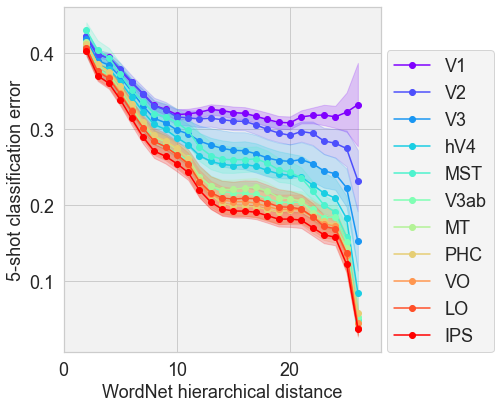

In [28]:
from scipy.stats import binned_statistic

fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.75, top=.95, wspace=0.3, hspace=0.3) 
for k,roi in enumerate(plot_roi):
    Y = []
    for s in roiwise_K_shot_err.keys():
        bin_means, bin_edges, binnumber = binned_statistic(offdiagonal(D_mat), offdiagonal(roiwise_K_shot_err[s][roi]),\
                                                       statistic='mean', bins=np.arange(0,30))
        Y += [bin_means,]
    Y = np.array(Y)
    subj_means = np.mean(Y, axis=0)
    subj_stds  = np.std(Y, axis=0) 
    plt.fill_between(bin_edges[:-1], subj_means-subj_stds, subj_means+subj_stds, color=roi_cmap[roi], alpha=.2)
    plt.plot(bin_edges[:-1], subj_means, marker='o', color=roi_cmap[roi], label=roi)   
plt.xlabel('WordNet hierarchical distance')
plt.ylabel('5-shot classification error')
plt.legend(loc=(1.02, 0.0))
plt.xlim([0, 28])

In [1511]:
filename = output_dir + "5-shot-accuracy_v_wordnet_distance%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

In [30]:
roi_subj_means, roi_subj_stds = [],[]
for k,roi in enumerate(plot_roi):
    Y = []
    for s in roiwise_K_shot_err.keys():
        bin_means, bin_edges, binnumber = binned_statistic(offdiagonal(D_mat), offdiagonal(roiwise_K_shot_err[s][roi]),\
                                                       statistic='mean', bins=[0, 6, 12, 18, 24, 30])
        Y += [bin_means,]
    Y = np.array(Y)
    subj_means = np.mean(Y, axis=0)
    subj_stds  = np.std(Y, axis=0) 
    roi_subj_means += [subj_means,]
    roi_subj_stds  += [subj_stds,]

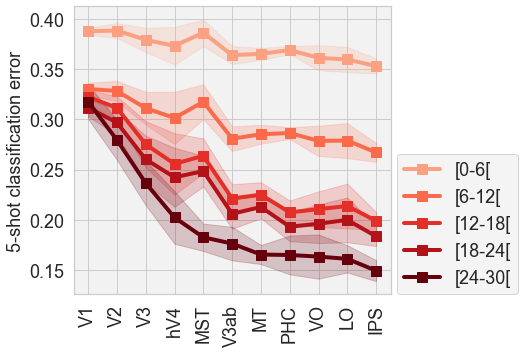

In [32]:
range_cmap = [cm.get_cmap('Reds', len(roi_subj_means[0])+2)(k+2) for k in range(len(roi_subj_means[0]))]

fig=plt.figure(figsize=(8,5))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.75, top=.95, wspace=0.3, hspace=0.3) 
Y_avg = np.zeros(len(plot_roi))
for k, (v,e,l) in enumerate(zip(np.array(roi_subj_means).T, np.array(roi_subj_stds).T, \
                                ['[0-6[', '[6-12[', '[12-18[', '[18-24[', '[24-30['])):
    plt.plot(np.arange(len(plot_roi)), v)
    
    plt.fill_between(np.arange(len(plot_roi)), v-e, v+e, color=range_cmap[k], alpha=.2)
    plt.plot(np.arange(len(plot_roi)), v, marker='s', ms=10, lw=4, color=range_cmap[k], label=l)  

_=plt.gca().set_xticks(np.arange(len(plot_roi)))
_=plt.gca().set_xticklabels(plot_roi, rotation=90)
plt.ylabel('5-shot classification error')
plt.legend(loc=(1.02, 0.))

In [1513]:
filename = output_dir + "m-shot_accuracy_vs_roi_per_wordnet_distance%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

## SNR distribution per subject and ROI

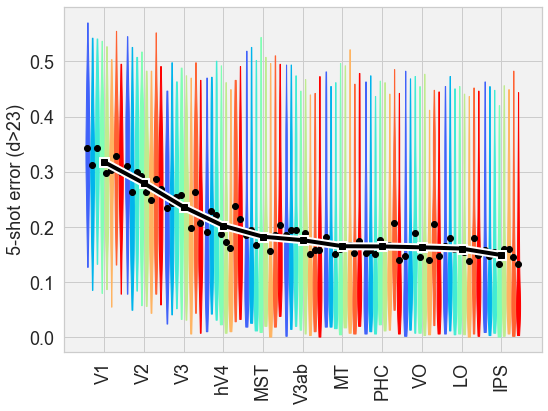

In [33]:
fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.98, top=.95, wspace=0.1, hspace=0.2)

m = D_mat.flatten()>=24 #np.logical_and(D_mat.flatten()>=25, D_mat.flatten()<rr[1])
    
subj_avg = []
for s in subjects:
    
    Y = [invalid_to_num((roiwise_K_shot_err[s][r].flatten())[m], np.mean) for r in plot_roi]
    Ymin, Ymax = [np.percentile(y, 1) for y in Y], [np.percentile(y, 99) for y in Y]
    Yf = [y[np.logical_and(y>ymin, y<ymax)] for y,ymin,ymax in zip(Y, Ymin, Ymax)]

    parts = plt.violinplot(Yf, \
        positions=np.arange(len(Y))+.12*s-0.54, \
        vert=True, widths=0.1, showmeans=False, showextrema=False, showmedians=False)

    for pc in parts['bodies']:
        pc.set_facecolor(subj_cmap[s])
        pc.set_edgecolor(subj_cmap[s])
        pc.set_alpha(1)

    values = np.array([np.mean(y) for y in Y])
    _=plt.plot(np.arange(len(Y))+.12*s-0.54, values, marker='o', ms=6, color='k', linestyle='None')
    subj_avg += [values,]
    
subj_avg = np.array(subj_avg)
_=plt.plot(np.arange(len(Y)), np.mean(subj_avg, axis=0), marker='s', ms=10, color='w', lw=8)
_=plt.plot(np.arange(len(Y)), np.mean(subj_avg, axis=0), marker='s', ms=6, color='k', lw=4)

_=plt.gca().set_xticks(np.arange(len(plot_roi)))
_=plt.gca().set_xticklabels(plot_roi, rotation=90)    
_=plt.ylabel('5-shot error (d>23)')

In [958]:
filename = output_dir + "5-shot-accuracy_wnD_above_24_per_ROI%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()